In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def load_data(train, test, fname) :
    fpath = "trained_models/resnet18_{}_piecewise_eps8_bs256_maxlr0.1_BNeval/eval/{}/{}.txt".format(train, test, fname)
    return np.loadtxt(fpath).astype(np.int)

train = "autoattack"
test = "pgd"

y_robust = load_data(train, test, "y_robust")
y_robust_pred = load_data(train, test, "y_robust_pred")
y_cross_robust = load_data(train, test, "y_cross_robust")
y_cross_robust_pred = load_data(train, test, "y_cross_robust_pred")

Let :

$Y = \{y_1, y_2, y_3, ... , y_n \}$ -> the original label

$P^{M_C}_{X_B} = \{p_1, p_2, p_3, ... , p_n \}$ -> the prediction of model $M_C$ on $X_B$

$E^{M}_{X_B} = \{id, \quad id \in Y \land id \in P^{M}_{X_B} \land y_{id} \neq p_{id} \}$ -> a list of failed test cases where prediction of the model ${M}$ is incorrect on $X_B$

$E^{M_C}_{X_B} = \{id, \quad id \in Y \land id \in P^{M_C}_{X_B} \land y_{id} \neq p_{id} \}$ -> a list of failed test cases where prediction of the robust ${M_C}$ is wrong for $X_B$

$Difference(List_1, List_2) = \{ id, \quad id \in List_1 \land id \not \in List_2 \}$

$R^C_B = Difference(E^{M}_{X_B}, E^{M_C}_{X_B})$

$R^B_B = Difference(E^{M}_{X_B}, E^{M_B}_{X_B})$

$Intersection(List_2, List_2) = \{ id, \quad id \in List_1 \land id \in List_2 \} $

Inspired from Jaccard simmilarity, we propose BSEM to measure the similarity of bug-attaccking behavior from adversarial attack

$BSEM_{C-fix-B} = \frac{Length(Intersection(R^C_B, R^B_B))}{Length(R^C_B) + Length(R^B_B) - Length(Intersection(R^C_B, R^B_B))}$

$BSEM_{B-fix-C} = \frac{Length(Intersection(R^B_C, R^C_C))}{Length(R^B_C) + Length(R^C_C) - Length(Intersection(R^B_C, R^C_C))}$

$BSEM(B,C) = \frac{BSEM_{B-fix-C} + BSEM_{C-fix-B}}{2}$

Failed Test Cases instead of Robust


In [38]:
def get_robust_data(train, test):
    y_adv = load_data(train, test, "y_cross_robust")
    y_adv_pred = load_data(train, test, "y_cross_robust_pred")
    return y_adv, y_adv_pred

train = "pgd"
test = "autoattack"
y_adv, y_adv_pred = get_robust_data(train, test)

print("Y_adv({},{}): {}".format(train, test, y_adv))
print("Y_adv_pred({},{}): {}".format(train, test, y_adv_pred))

Y_adv(pgd,autoattack): [3 8 8 ... 5 1 7]
Y_adv_pred(pgd,autoattack): [3 8 0 ... 5 1 7]


In [173]:
train = "fgsm"
test = "autopgd"
y_adv, y_adv_pred = get_robust_data(train, test)

print("Y_adv({},{}): {}".format(train, test, y_adv))
print("Y_adv_pred({},{}): {}".format(train, test, y_adv_pred))

Y_adv(fgsm,autopgd): [3 8 8 ... 5 1 7]
Y_adv_pred(fgsm,autopgd): [3 8 8 ... 5 0 7]


In [187]:
def error(l1, l2):
    if len(l1) != len(l2) :
        raise ValueError("The array length must be same")
    check = np.not_equal(l1, l2)
    return np.argwhere(check == True).reshape(-1)

def correct(l1, l2):
    if len(l1) != len(l2) :
        raise ValueError("The array length must be same")
    check = np.equal(l1, l2)
    return np.argwhere(check == True).reshape(-1)    

def repair(l1, l2) :
#     return [x for x in l1 if x not in l2]
    return l1[np.isin(l1, l2, invert=True)]

y1, y1_pred = get_robust_data("original", test)
y2, y2_pred = get_robust_data(train, test)



In [188]:
l1 = [0,1,2] 
l2 = [0,5,2]
error([0,1,2], [0,5,2])

array([1])

In [189]:
correct(l1, l2)

array([0, 2])

In [257]:
def get_correct(train, test):
    y, y_pred = get_robust_data(train, test)
    return correct(y, y_pred)
    

def get_distribution(train, test):
    correct_original_test = get_correct("original", test)
    correct_train_test = get_correct(train, test)
    correct_test_test = get_correct(test, test)
    n = len(load_data(train, test, "y_cross_robust"))
    l = np.zeros(n).astype(np.int)
    for i in range(len(l)):
        if i in correct_original_test :
            l[i] = 1
        elif i in correct_train_test :
            l[i] = 2
        elif i in correct_test_test :
            l[i] = 3
        if i in correct_train_test and i in correct_test_test :
            l[i] = 4
            
    unique, counts = np.unique(l, return_counts=True)
    counter = dict(zip(unique, counts))
    index = []
    data = []
    for i in range(5) :
        index.append(i)
        if i in unique :
            data.append(counter[i])
        else :
            data.append(0)
            
#     print(counter)

    return pd.DataFrame(data={"index": index, "count": data})

<AxesSubplot:xlabel='index', ylabel='count'>

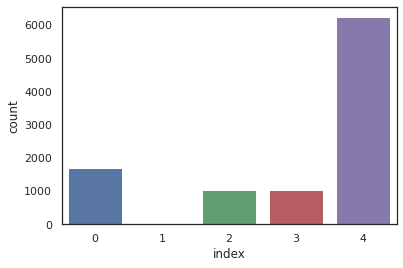

In [258]:
df = get_distribution("autoattack", "pgd")
sns.barplot(data=df, x="index", y="count")

<AxesSubplot:xlabel='index', ylabel='count'>

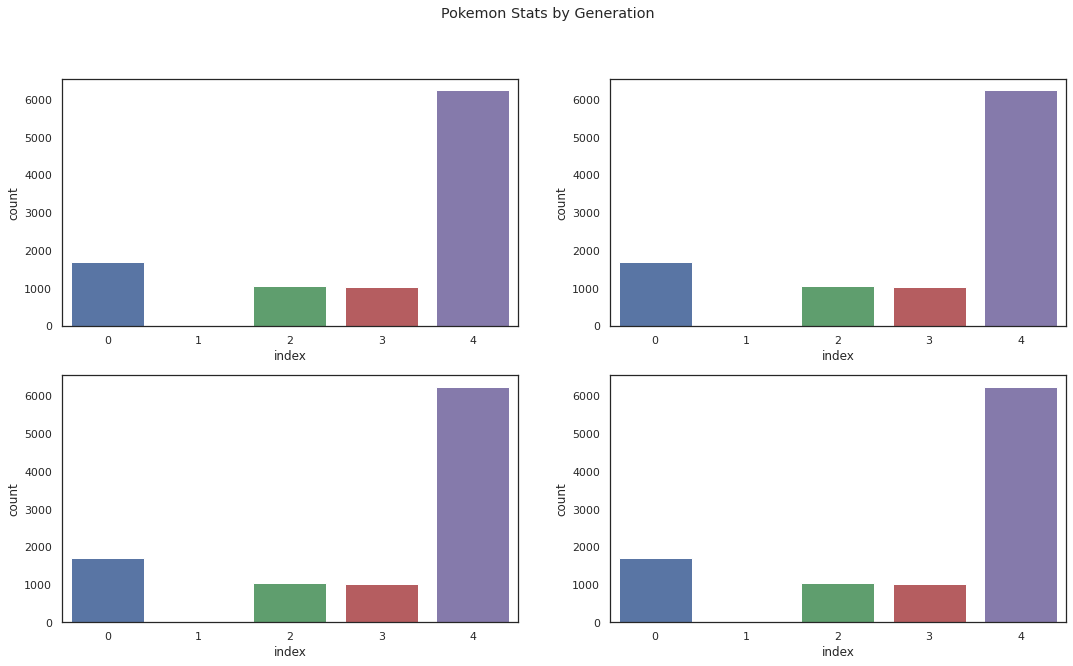

In [253]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Pokemon Stats by Generation')

sns.barplot(ax=axes[0, 0], data=df, x='index', y="count")
sns.barplot(ax=axes[0, 1], data=df, x='index', y="count")
sns.barplot(ax=axes[1, 0], data=df, x='index', y="count")
sns.barplot(ax=axes[1, 1], data=df, x='index', y="count")

In [271]:
distributions = {}
for x1 in attacks :
    d = {}
    for x2 in attacks :
        train = x1
        test = x2
        d[x2] = get_distribution(train, test)
    distributions[x1] = d

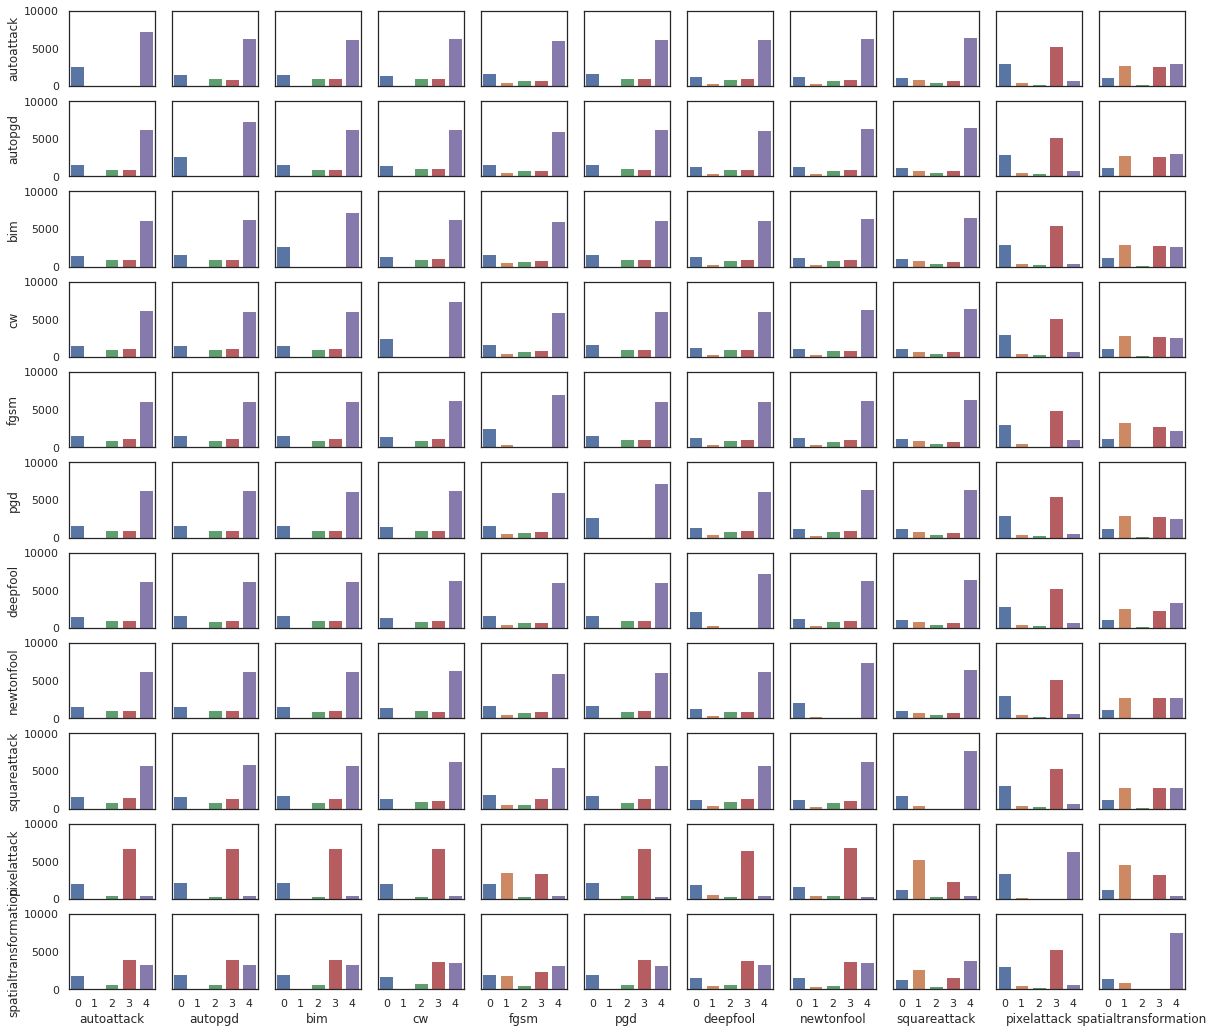

In [283]:
m = len(attacks)
# m = 3
fig, axes = plt.subplots(m, m, figsize=(20, 18))

g = {}

for i in range(m) :
    g[i] = {}
    for j in range(m) :
        train = attacks[i]
        test = attacks[j]
        df = pd.DataFrame(data=distributions[train][test])
        axes[i, j].set(ylim=(0, 10000))
        g[i][j] = sns.barplot(ax=axes[i, j], data=df, x='index', y="count")
    
        if i != m-1 :
            g[i][j].set(xticklabels=[])  
            g[i][j].set(xlabel=None)
            g[i][j].tick_params(bottom=False)  # remove the ticks
        else :
            g[i][j].set(xlabel=test)
        
        
        if j != 0 :
            g[i][j].set(yticklabels=[])  
            g[i][j].set(ylabel=None)
            g[i][j].tick_params(top=False)  # remove the ticks
        else :
            g[i][j].set(ylabel=train)

fig.savefig("plot/dist.png", bbox_inches='tight')

In [184]:
R = repair(error(y1, y1_pred), error(y2, y2_pred))
len(R)

7289

In [81]:
def match(l1, l2) :
#     return [x for x in l1 if x in l2]
    return l1[np.isin(l1, l2)]

len(match(R,R))

7289

In [164]:
def get_repair(train, test): 
    y1, y1_pred = get_robust_data("original", test)
    y2, y2_pred = get_robust_data(train, test)
    R = repair(error(y1, y1_pred), error(y2, y2_pred))
    return R

def is_not_subset(train, test) :
    R_train_test = get_repair(train, test)
    R_test_test = get_repair(test, test)
    
#     return len(repair(R_test_test, R_train_test)) > 0 
    return len(repair(R_train_test, R_test_test)) > 0 

def one_pov_relation(train, test) :
    R_train_test = get_repair(train, test)
    R_test_test = get_repair(test, test)
    
    intersection = len(match(R_train_test, R_test_test))
    union = len(R_train_test) + len(R_test_test) - intersection
    
    return intersection / union

one_pov_relation(train, test)

0.7565426170468187

In [165]:
def BSEM(a1, a2) :
    return (one_pov_relation(a1, a2) + one_pov_relation(a2, a1))/2

BSEM(train, test)

0.7538137386101982

In [166]:
BSEM("pixelattack", "autoattack")

0.09236401499721504

In [167]:
BSEM("squareattack", "autoattack")

0.6442275274749332

In [168]:
BSEM("pgd", "fgsm")

0.6829271124477849

In [169]:
BSEM("cw", "fgsm")

0.6825935513920007

In [170]:
from constant import TOOLBOX_ADV_ATTACK_LIST

# TOOLBOX_ADV_ATTACK_LIST = ["autoattack", "deepfool", "fgm", "pgd", "squareattack"]

TOOLBOX_ADV_ATTACK_LIST = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "deepfool", "newtonfool", "squareattack", "pixelattack", "spatialtransformation"]
# TOOLBOX_ADV_ATTACK_LIST = ["autoattack", "autopgd", "bim", "cw", "deepfool", "fgsm", "jsma", "newtonfool", "pixelattack", "pgd",  "squareattack"]

attacks = TOOLBOX_ADV_ATTACK_LIST

In [171]:
metrics = {}
for a1 in attacks :
    m = {}
    for a2 in attacks :
        m[a2] = is_not_subset(a1, a2)
    metrics[a1] = m  
    
rq1 = pd.DataFrame(data=metrics)

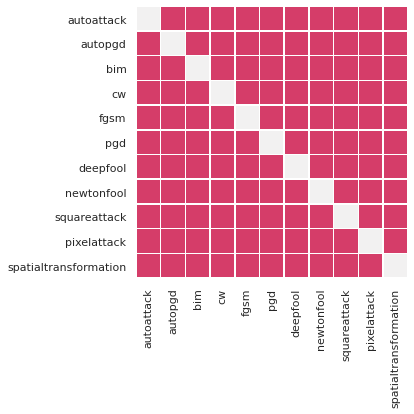

In [172]:
def plot_half_heatmap(data, cmap, path) :
    sns.set_theme(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(different_bugs_metrics, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 5))

    # Draw the heatmap with the mask and correct aspect ratio
    f = sns.heatmap(data, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar=False)
    f.figure.savefig(path, bbox_inches='tight')

def plot_heatmap(data, cmap, path, annot=False) :
    sns.set_theme(style="white")

    # Draw the heatmap with the mask and correct aspect ratio
    if annot :
        f, ax = plt.subplots(figsize=(12, 6))
        f = sns.heatmap(data, cmap=cmap, vmax=1, center=0, annot=annot, fmt=".3f",
                        linewidths=.5, cbar_kws={"shrink": .5})
        f.figure.savefig(path, bbox_inches='tight')
    else :
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(8, 5))
        f = sns.heatmap(data, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar=False)
        f.figure.savefig(path, bbox_inches='tight')


# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0,s=75, l=50, n=1, as_cmap=True)

path = "plot/rq1-is-not-subset.png"

plot_heatmap(rq1, cmap, path)

In [158]:
metrics = {}
for a1 in attacks :
    m = {}
    for a2 in attacks :
        m[a2] = one_pov_relation(a1, a2)
    metrics[a1] = m  
    
one_bsem = pd.DataFrame(data=metrics)

In [159]:
# def plot_heatmap(data, cmap, path, annot=False) :
#     sns.set_theme(style="white")

#     # Draw the heatmap with the mask and correct aspect ratio
#     if annot :
#         f, ax = plt.subplots(figsize=(12, 6))
#         f = sns.heatmap(data, cmap=cmap, vmax=1, center=0, annot=annot, fmt=".3f",
#                         linewidths=.5, cbar_kws={"shrink": .5})
#         f.figure.savefig(path, bbox_inches='tight')
#     else :
#         # Set up the matplotlib figure
#         f, ax = plt.subplots(figsize=(8, 5))
#         f = sns.heatmap(data, cmap=cmap, vmax=1, center=0,
#                 square=True, linewidths=.5, cbar=False)
#         f.figure.savefig(path, bbox_inches='tight')

def plot_heatmap(metrics, cmap, fpath, vmin, vmax, annot=True): 

    df = pd.DataFrame(data=metrics)

    plt.figure(figsize=(12,9))
    fig = sns.heatmap(df, cmap=cmap, vmin=vmin, vmax=vmax, annot=annot, fmt=".3f", linewidth=0.7)
#     fig.set(xlabel='Train', ylabel='Test')
    fig.figure.savefig(fpath, bbox_inches='tight')
    plt.show()

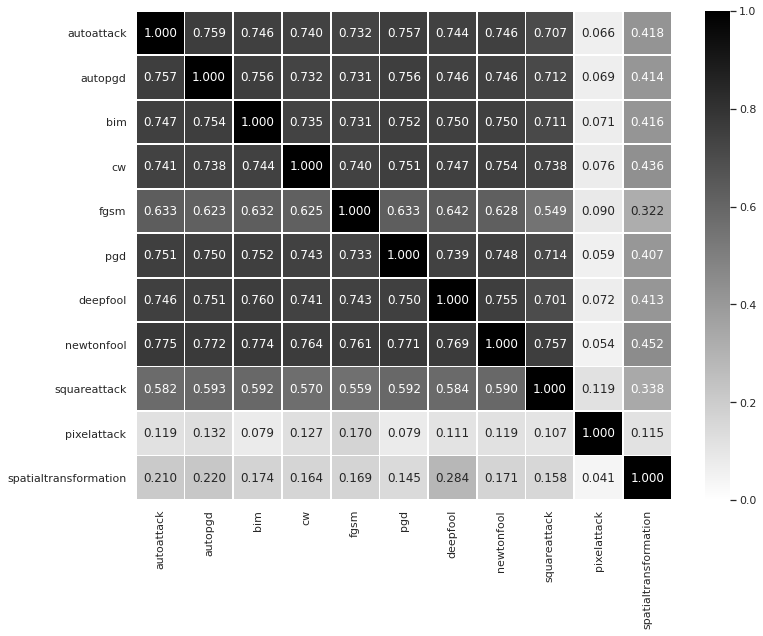

In [148]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0,s=75, l=50, n=1, as_cmap=True)

path = "plot/rq2-one-bsem.png"

plot_heatmap(one_bsem, "binary", path, 0, 1)

In [149]:
metrics = {}
for a1 in attacks :
    m = {}
    for a2 in attacks :
        m[a2] = BSEM(a1, a2)
    metrics[a1] = m  
    
bsem = pd.DataFrame(data=metrics)

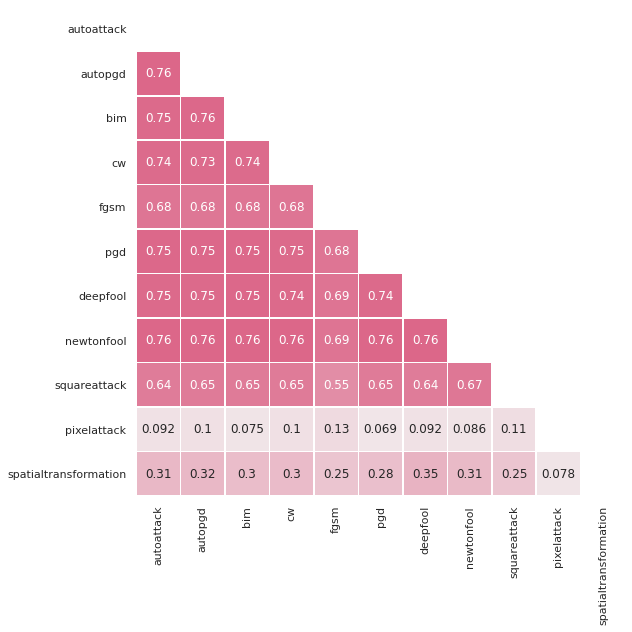

In [150]:
def plot_half_heatmap(data, cmap, path) :
    sns.set_theme(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(data, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    f = sns.heatmap(data, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar=False, annot=True)
    f.figure.savefig(path, bbox_inches='tight')


# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0,s=75, l=50, n=1, as_cmap=True)

path = "plot/rq2-bsem.png"

plot_half_heatmap(bsem, cmap, path)

In [175]:
!pip install scipy

In [179]:
1-bsem

,autoattack,autopgd,bim,cw,fgsm,pgd,deepfool,newtonfool,squareattack,pixelattack,spatialtransformation
autoattack,0.000000,0.242130,0.253505,0.259234,0.317303,0.246186,0.254940,0.239486,0.355772,0.907636,0.685767
autopgd,0.242130,0.000000,0.244825,0.265004,0.322815,0.247167,0.251366,0.240830,0.347600,0.899475,0.683315
bim,0.253505,0.244825,0.000000,0.260207,0.318461,0.248241,0.245264,0.238091,0.348597,0.925118,0.704993
cw,0.259234,0.265004,0.260207,0.000000,0.317406,0.252756,0.256309,0.241084,0.345961,0.898943,0.699913
fgsm,0.317303,0.322815,0.318461,0.317406,0.000000,0.317073,0.307451,0.305612,0.446162,0.870010,0.754115
pgd,0.246186,0.247167,0.248241,0.252756,0.317073,0.000000,0.255642,0.240564,0.347046,0.930979,0.723793
deepfool,0.254940,0.251366,0.245264,0.256309,0.307451,0.255642,0.000000,0.238114,0.357331,0.908408,0.651153
newtonfool,0.239486,0.240830,0.238091,0.241084,0.305612,0.240564,0.238114,0.000000,0.326338,0.913725,0.688699
squareattack,0.355772,0.347600,0.348597,0.345961,0.446162,0.347046,0.357331,0.326338,0.000000,0.886645,0.752095
pixelattack,0.907636,0.899475,0.925118,0.898943,0.870010,0.930979,0.908408,0.913725,0.886645,0.000000,0.922147


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


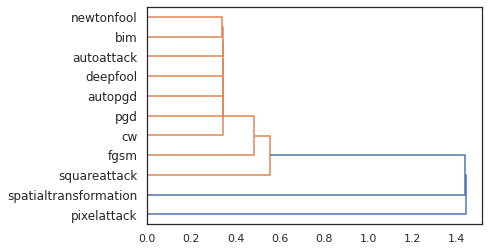

In [182]:
import scipy.cluster.hierarchy as hcluster
linkage = hcluster.linkage(1 - bsem)
dendro  = hcluster.dendrogram(linkage, labels=bsem.columns, orientation="right")